# Adaptive Backend Benchmark

Performance comparison between CPU and Adaptive backends.

In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import rust_indicators
from pycoingecko import CoinGeckoAPI
import time
import os

cg = CoinGeckoAPI()

In [8]:
# Setup backends
os.environ['RUST_INDICATORS_DEVICE'] = 'cpu'
cpu_ta = rust_indicators.RustTA()

if 'RUST_INDICATORS_DEVICE' in os.environ:
    del os.environ['RUST_INDICATORS_DEVICE']
adaptive_ta = rust_indicators.RustTA()

print(f"CPU: {cpu_ta.device()}, Adaptive: {adaptive_ta.device()}")

CPU: cpu, Adaptive: cpu


In [9]:
# Get data
data = cg.get_coin_market_chart_by_id('bitcoin', 'usd', 7)
df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df['volume'] = pd.DataFrame(data['total_volumes'])[1]

# Generate buy/sell volumes
price_changes = df['price'].pct_change().fillna(0)
buy_ratio = 0.5 + 0.3 * np.tanh(price_changes / price_changes.std())
df['buy_volume'] = df['volume'] * buy_ratio
df['sell_volume'] = df['volume'] * (1 - buy_ratio)

print(f"Data points: {len(df)}")

Data points: 168


In [10]:
# Benchmark function
def benchmark_backend(backend, name, sizes):
    results = []
    
    for size in sizes:
        buy_vols = df['buy_volume'].iloc[:size].values
        sell_vols = df['sell_volume'].iloc[:size].values
        
        times = []
        for _ in range(3):
            start = time.time()
            backend.vpin(buy_vols, sell_vols, 50)
            times.append(time.time() - start)
        
        avg_time = np.mean(times)
        throughput = size / avg_time
        
        results.append({
            'size': size,
            'time': avg_time,
            'throughput': throughput,
            'backend': name
        })
        
        print(f"{name} {size:5d}: {avg_time:.4f}s ({throughput:,.0f} pts/s)")
    
    return results

# Run benchmarks
sizes = [1000, 2000, 3000, 4000, 5000, 7500, 10000]
cpu_results = benchmark_backend(cpu_ta, 'CPU', sizes)
adaptive_results = benchmark_backend(adaptive_ta, 'Adaptive', sizes)

CPU  1000: 0.0000s (213,269,695 pts/s)
CPU  2000: 0.0000s (1,048,576,000 pts/s)
CPU  3000: 0.0000s (1,572,864,000 pts/s)
CPU  4000: 0.0000s (2,188,332,522 pts/s)
CPU  5000: 0.0000s (3,145,728,000 pts/s)
CPU  7500: 0.0000s (3,932,160,000 pts/s)
CPU 10000: 0.0000s (5,991,862,857 pts/s)
Adaptive  1000: 0.0000s (524,288,000 pts/s)
Adaptive  2000: 0.0000s (1,094,166,261 pts/s)
Adaptive  3000: 0.0000s (1,641,249,391 pts/s)
Adaptive  4000: 0.0000s (2,097,152,000 pts/s)
Adaptive  5000: 0.0000s (2,621,440,000 pts/s)
Adaptive  7500: 0.0000s (3,932,160,000 pts/s)
Adaptive 10000: 0.0000s (5,719,505,455 pts/s)


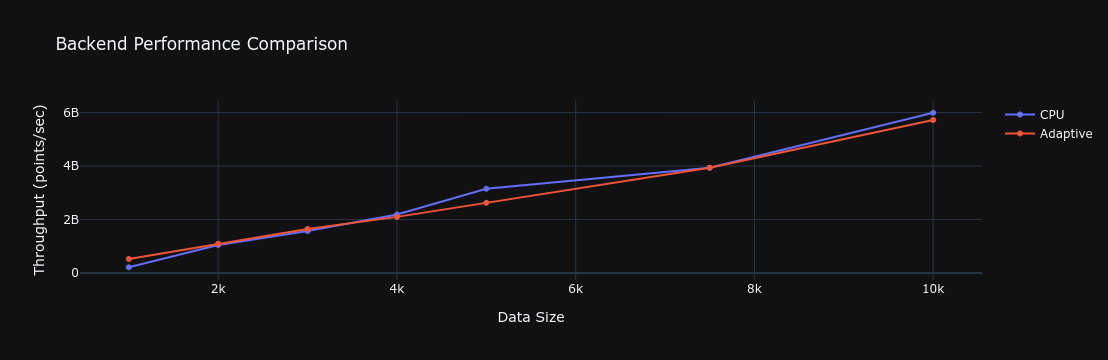

In [11]:
# Plot results
results_df = pd.DataFrame(cpu_results + adaptive_results)

fig = go.Figure()

for backend in ['CPU', 'Adaptive']:
    data = results_df[results_df['backend'] == backend]
    fig.add_trace(go.Scatter(
        x=data['size'], y=data['throughput'],
        name=backend, mode='lines+markers'
    ))

fig.update_layout(
    title='Backend Performance Comparison',
    xaxis_title='Data Size',
    yaxis_title='Throughput (points/sec)',
    template='plotly_dark'
)

fig.show()

In [12]:
# Summary
cpu_avg = np.mean([r['throughput'] for r in cpu_results])
adaptive_avg = np.mean([r['throughput'] for r in adaptive_results])
speedup = adaptive_avg / cpu_avg

print(f"CPU Average: {cpu_avg:,.0f} pts/s")
print(f"Adaptive Average: {adaptive_avg:,.0f} pts/s")
print(f"Speedup: {speedup:.2f}x")

CPU Average: 2,584,684,725 pts/s
Adaptive Average: 2,518,565,872 pts/s
Speedup: 0.97x
